./1_data/Tb3Ni@85K.gr 85
MagStructure creation from mcif file successful.
['a', 'b', 'c', 'nucscale']
['a', 'b', 'c', 'U11_0', 'U22_0', 'U33_0', 'U12_0', 'U13_0', 'U23_0', 'U33_8', 'U13_8', 'U11_8', 'U22_8', 'U33_12', 'U13_12', 'U11_12', 'U22_12', 'nucscale']
['a', 'b', 'c', 'U11_0', 'U22_0', 'U33_0', 'U12_0', 'U13_0', 'U23_0', 'U33_8', 'U13_8', 'U11_8', 'U22_8', 'U33_12', 'U13_12', 'U11_12', 'U22_12', 'nucscale', 'delta2']
['a', 'b', 'c', 'U11_0', 'U22_0', 'U33_0', 'U12_0', 'U13_0', 'U23_0', 'U33_8', 'U13_8', 'U11_8', 'U22_8', 'U33_12', 'U13_12', 'U11_12', 'U22_12', 'nucscale', 'delta2', 'parascale', 'ordscale', 'th', 'phi']


/usr/local/Caskroom/miniconda/base/envs/37/lib/python3.7/site-packages/diffpy.srfit-3.0.0-py3.7.egg/diffpy/srfit/fitbase/fitresults.py:174: RuntimeWarning: divide by zero encountered in true_divide
  self.cov = numpy.dot(vh.T.conj()/s**2,vh)
/usr/local/Caskroom/miniconda/base/envs/37/lib/python3.7/site-packages/diffpy.srfit-3.0.0-py3.7.egg/diffpy/srfit/fitbase/fitresults.py:174: RuntimeWarning: invalid value encountered in true_divide
  self.cov = numpy.dot(vh.T.conj()/s**2,vh)


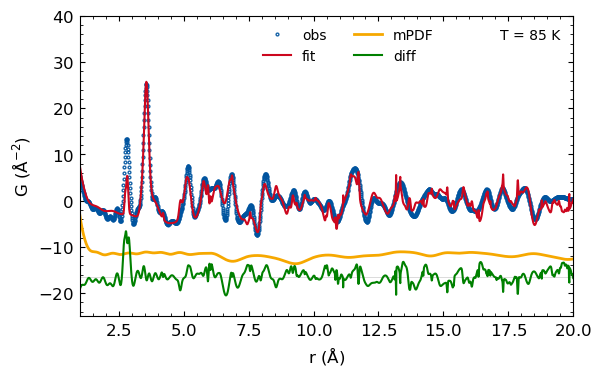

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import typing
from diffpy.mpdf import *
from pathlib import Path
from ezplot import plot_defaults
from diffpy.mpdf.mciftools import create_from_mcif
from diffpy.srfit.fitbase import FitContribution, FitRecipe, FitResults, Profile
from diffpy.srfit.pdf import PDFGenerator, PDFParser
from diffpy.structure import loadStructure
from diffpy.structure.parsers import getParser
from scipy.optimize import least_squares

from glob import glob

def _get_tags(phase: str, param: str) -> typing.List[str]:
    return [param, phase, "{}_{}".format(phase, param)]


def _get_name(*args: str) -> str:
    return "_".join(args)





def combined_fit(dataFile, structureFile, rmin=1.5, rmax=20.0, method="corefinement"):
    dF = Path(dataFile)
    Temperature = dataFile.split("@")[-1].split(".")[0][:-1]
    print(dataFile, Temperature)
    """
    method = 'corefinement': true simultaneous corefinement
    of atomic and magnetic parameters
    method = 'toggle': iterative fit that toggles between
    atomic and magnetic parameters
    """
    # load in the starting structure
    pcif = getParser("cif")
    struc = pcif.parseFile(structureFile)

    # prepare profile object with experimental data
    profile = Profile()
    parser = PDFParser()
    parser.parseFile(dataFile)
    profile.loadParsedData(parser)

    # define qdamp and qbroad (determined previously from calibration fits)
    qdamp = 0.025
    qbroad = 0.025

    # set up calculation range for the PDF simulation
    rstep = 0.01
    profile.setCalculationRange(xmin=rmin, xmax=rmax, dx=rstep)

    # prepare the function that calculates the atomic PDF
    nucpdf = PDFGenerator("nucpdf")  # this will calculate the atomic PDF
    nucpdf.setStructure(struc)
    nucpdf.setProfile(profile)

    # prepare a FitContribution object that will include the atomic and magnetic PDF
    totpdf = FitContribution("totpdf")
    totpdf.addProfileGenerator(nucpdf)  # we'll add the mPDF later
    totpdf.setProfile(profile)

    # set up the MagSpecies
    mspec = MagSpecies(struc=struc, rmaxAtoms=rmax, ffparamkey="Mn2")
    mspec.strucIdxs = [0, 1, 2]  # determined from previous inspection of the unit cell
    mspec.basisvecs = np.array(
        [1, -1, 0]
    )  # any vector perpendicular to the c axis will be fine
    mspec.kvecs = np.array(
        [0, 0, 1.5]
    )  # this gives the desired AF structure for this choice of unit cell

    # set up the MagStructure
    mstruc = create_from_mcif("./0_cifs/Tb3Ni@58K.mcif", ffparamkey="Tb3")
    #mstruc = MagStructure(rmaxAtoms=rmax)
    #mstruc.loadSpecies(mspec)
    mstruc.makeAll()  ### populates the spin and atom arrays

    # create the MPDFcalculator for MnO
    mc = MPDFcalculator(magstruc=mstruc, qdamp=qdamp, rmax=rmax, rmin=rmin)

    # Define an mPDF function that will be added to the total PDF calculator
    def mpdf(ordscale, parascale, th, phi):
        """
        ordscale = ordered scale factor (mc.ordScale)
        parascale = paramagnetic scale factor (mc.paraScale)
        th, phi = polar and azimuthal angles of sublattice magnetization direction
        """
        mc.ordScale = ordscale
        mc.paraScale = parascale
        # define a new sublattice magnetization direction based on th, phi
        newSvec = np.array(
            [np.sin(th) * np.cos(phi), np.sin(th) * np.sin(phi), np.cos(th)]
        )
        # update the MagStructure with the new spin directions
        mspec.basisvecs = 1.0 * newSvec
        mstruc.makeAll()
        # return the "unnormalized" mPDF
        rcalc, fcalc, dcalc = mc.calc(both=True)
        return dcalc

    # add mPDF to the FitContribution
    totpdf.registerFunction(mpdf)
    totpdf.setEquation("nucscale * nucpdf + mpdf(ordscale,parascale,th,phi)")

    # Make magnetic PDF depend on any changes to the atomic structure.
    # A structure change will now trigger reevaluation of the mPDF.
    nucpdf.phase.addObserver(totpdf.ordscale.notify)

    # set up the FitRecipe
    fit = FitRecipe()
    fit.addContribution(totpdf)

    # fix qdamp and qbroad based on prior information
    fit.addVar(nucpdf.qdamp, qdamp, fixed=True, name="qdamp")
    fit.addVar(nucpdf.qbroad, qbroad, fixed=True, name="qbroad")

    # Configure the fit variables and give them to the recipe.
    from diffpy.srfit.structure import constrainAsSpaceGroup

    sgpars = constrainAsSpaceGroup(nucpdf.phase, pcif.spacegroup.short_name)

    for par in sgpars.latpars:
        fit.addVar(par, tag="LatPars")  # we will use these tags later
    for par in sgpars.adppars:
        fit.addVar(par, value=0.003, tag="ADPs")


    # note that there are no positional degrees of freedom (i.e. xyz parameters) for this structure

    fit.addVar(totpdf.nucscale, 0.05, name="nucscale")
    fit.addVar(nucpdf.delta2, value=1.0, name="delta2")

    # mPDF parameters
    fit.addVar(totpdf.parascale, 0, tag="Mag")
    rstPs = fit.restrain(
        totpdf.parascale, lb=0, ub=10.0, sig=0.0001
    )  # set reasonable bounds
    fit.addVar(totpdf.ordscale, 0.0, tag="Mag")
    rstOs = fit.restrain(totpdf.ordscale, lb=0, ub=10.0, sig=0.0001)
    fit.addVar(totpdf.th, np.pi / 2.0, tag="Mag")
    rstTh = fit.restrain(totpdf.th, lb=0, ub=np.pi, sig=0.0001)
    fit.addVar(totpdf.phi, 0, tag="Mag")
    rstPhi = fit.restrain(totpdf.phi, lb=-np.pi, ub=np.pi, sig=0.0001)

    # Turn off printout of iteration number.
    fit.clearFitHooks()
    fit.fix("all")

    if method == "corefinement":
        # start with scale factor and lattice parameters
        fit.free("nucscale")
        fit.free("LatPars")  # we use the tag LatPars to free all the lattice parameters
        print(fit.names)
        least_squares(fit.residual, fit.values)

        # skipping xyz parameters because there are none in this symmetry

        # add the ADps
        fit.free("ADPs")
        print(fit.names)
        least_squares(fit.residual, fit.values)

        # add delta1
        fit.free("delta2")
        print(fit.names)
        least_squares(fit.residual, fit.values)

        # add the magnetic parameters
        fit.free("Mag")
        print(fit.names)
        least_squares(fit.residual, fit.values)

    if method == "toggle":
        numIterations = (
            3  # number of times to toggle between atomic and magnetic parameters
        )
        for i in range(numIterations):
            # start with scale factor and lattice parameters
            fit.free("nucscale")
            fit.free(
                "LatPars"
            )  # we use the tag LatPars to free all the lattice parameters
            print(fit.names)
            least_squares(fit.residual, fit.values)

            # skipping xyz parameters because there are none in this symmetry

            # add the ADps
            fit.free("ADPs")
            print(fit.names)
            least_squares(fit.residual, fit.values)

            # add delta1
            fit.free("delta2")
            print(fit.names)
            least_squares(fit.residual, fit.values)

            # now fix all the atomic parameters and free the magnetic parameters
            fit.fix("all")

            fit.free("Mag")
            print(fit.names)
            magOpt = least_squares(fit.residual, fit.values)

            if i < (numIterations - 1):
                fit.fix("all")  # fix all the parameters and start the loop again

    # Display results and plot the fit
    r = fit.totpdf.profile.x
    gobs = fit.totpdf.profile.y

    # Get the calculated PDF and compute the difference between the calculated and
    # measured PDF
    totcalc = fit.totpdf.evaluate()  # calculated combined atomic and magnetic PDF
    magcalc = mpdf(
        fit.ordscale.value, fit.parascale.value, fit.th.value, fit.phi.value
    )  # just mPDF
    nuccalc = totcalc - magcalc  # just atomic PDF
    baseline = 1.6 * gobs.min()
    nucdiff = gobs - nuccalc
    totdiff = gobs - totcalc  # total fit residual
    results = FitResults(fit)
    results.saveResults(f"Results_{dF.stem}.res")

    

    fig, gs = plot_defaults(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    ax.set_xlim(1, max(r))
    ax.set_ylim(-25, 40)

    

    ax.set_xlabel(r"r ($\mathdefault{\AA}$)")
    ax.set_ylabel(r"G ($\mathdefault{\AA^{-2}}$)")
    ax.plot(r, gobs, "bo", label="obs", markerfacecolor="none", markeredgecolor="C0",  markersize=2, alpha=0.9)
    ax.plot(r, totcalc, label="fit", alpha=1, color="C1")
    ax.plot(r, magcalc + baseline, marker="None", color="C3", lw=2, label="mPDF")
    ax.plot(r, np.zeros_like(r) + 1.4 * baseline, "k", linewidth=0.1)
    ax.plot(r, totdiff + 1.4 * baseline, "g-", label="diff")
    ax.plot([],[], label=f"T = {Temperature} K", linestyle="")
    plt.legend(frameon=False, ncol=3, fontsize=10)

    plt.savefig(f"Plot_{dF.stem}.pdf")
    return fit, mpdf, dF


for dataFile in glob('./1_data/Tb3Ni*.gr')[::-1]:

    structureFile = '0_cifs/Tb3Ni.cif'
    fit, mpdf, dF = combined_fit(dataFile, structureFile, rmin=0.2, rmax=20, method='corefinement')
    break


/usr/local/Caskroom/miniconda/base/envs/37/lib/python3.7/site-packages/diffpy.srfit-3.0.0-py3.7.egg/diffpy/srfit/fitbase/fitresults.py:174: RuntimeWarning: divide by zero encountered in true_divide
  self.cov = numpy.dot(vh.T.conj()/s**2,vh)
/usr/local/Caskroom/miniconda/base/envs/37/lib/python3.7/site-packages/diffpy.srfit-3.0.0-py3.7.egg/diffpy/srfit/fitbase/fitresults.py:174: RuntimeWarning: invalid value encountered in true_divide
  self.cov = numpy.dot(vh.T.conj()/s**2,vh)


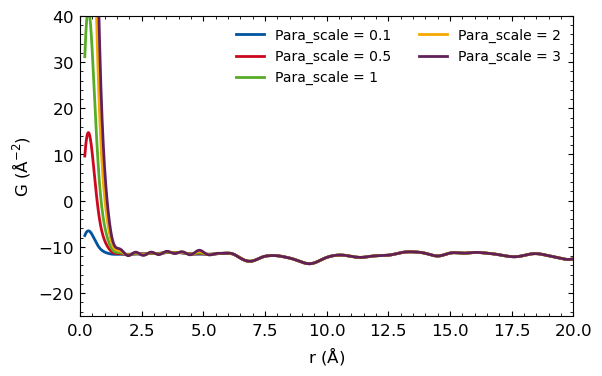

In [11]:
fig, gs = plot_defaults(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim(0, max(r))
ax.set_ylim(-25, 40)

# Display results and plot the fit
for pscale in [0.1, 0.5, 1, 2, 3]:
    fit.parascale = pscale
    r = fit.totpdf.profile.x
    gobs = fit.totpdf.profile.y

    # Get the calculated PDF and compute the difference between the calculated and
    # measured PDF
    totcalc = fit.totpdf.evaluate()  # calculated combined atomic and magnetic PDF
    magcalc = mpdf(
    fit.ordscale.value, fit.parascale.value, fit.th.value, fit.phi.value
    )  # just mPDF
    nuccalc = totcalc - magcalc  # just atomic PDF
    baseline = 1.6 * gobs.min()
    nucdiff = gobs - nuccalc
    totdiff = gobs - totcalc  # total fit residual
    results = FitResults(fit)

    ax.plot(r, magcalc + baseline, marker="None", lw=2, label=f"Para_scale = {pscale}")






ax.set_xlabel(r"r ($\mathdefault{\AA}$)")
ax.set_ylabel(r"G ($\mathdefault{\AA^{-2}}$)")
#ax.plot(r, gobs, "bo", label="obs", markerfacecolor="none", markeredgecolor="C0",  markersize=2, alpha=0.9)
#ax.plot(r, totcalc, label="fit", alpha=1, color="C1")

#ax.plot(r, np.zeros_like(r) + 1.4 * baseline, "k", linewidth=0.1)
#ax.plot(r, totdiff + 1.4 * baseline, "g-", label="diff")
#ax.plot([],[], label=f"T = {Temperature} K", linestyle="")
plt.legend(frameon=False, ncol=2, fontsize=10)

plt.savefig(f"Sim_Para_Scale.pdf")

/usr/local/Caskroom/miniconda/base/envs/37/lib/python3.7/site-packages/diffpy.srfit-3.0.0-py3.7.egg/diffpy/srfit/fitbase/fitresults.py:230: RuntimeWarning: invalid value encountered in double_scalars
  cond[i] /= 2*h
/usr/local/Caskroom/miniconda/base/envs/37/lib/python3.7/site-packages/diffpy.srfit-3.0.0-py3.7.egg/diffpy/srfit/fitbase/fitresults.py:237: RuntimeWarning: invalid value encountered in true_divide
  r.append(rk/(2*h))


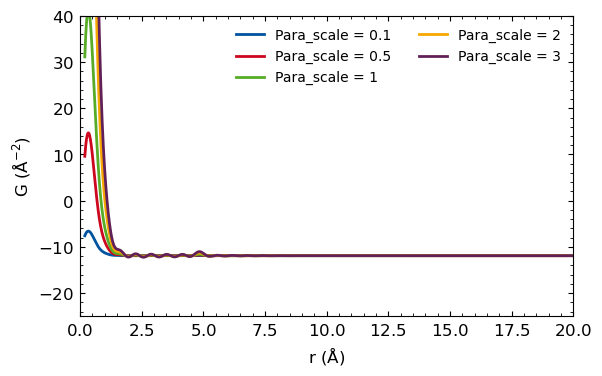

In [13]:
fig, gs = plot_defaults(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim(0, max(r))
ax.set_ylim(-25, 40)

# Display results and plot the fit
for pscale in [0.1, 0.5, 1, 2, 3]:
    fit.ordscale = 0
    fit.parascale = pscale
    r = fit.totpdf.profile.x
    gobs = fit.totpdf.profile.y

    # Get the calculated PDF and compute the difference between the calculated and
    # measured PDF
    totcalc = fit.totpdf.evaluate()  # calculated combined atomic and magnetic PDF
    magcalc = mpdf(
    fit.ordscale.value, fit.parascale.value, fit.th.value, fit.phi.value
    )  # just mPDF
    nuccalc = totcalc - magcalc  # just atomic PDF
    baseline = 1.6 * gobs.min()
    nucdiff = gobs - nuccalc
    totdiff = gobs - totcalc  # total fit residual
    results = FitResults(fit)

    ax.plot(r, magcalc + baseline, marker="None", lw=2, label=f"Para_scale = {pscale}")






ax.set_xlabel(r"r ($\mathdefault{\AA}$)")
ax.set_ylabel(r"G ($\mathdefault{\AA^{-2}}$)")
#ax.plot(r, gobs, "bo", label="obs", markerfacecolor="none", markeredgecolor="C0",  markersize=2, alpha=0.9)
#ax.plot(r, totcalc, label="fit", alpha=1, color="C1")

#ax.plot(r, np.zeros_like(r) + 1.4 * baseline, "k", linewidth=0.1)
#ax.plot(r, totdiff + 1.4 * baseline, "g-", label="diff")
#ax.plot([],[], label=f"T = {Temperature} K", linestyle="")
plt.legend(frameon=False, ncol=2, fontsize=10)

plt.savefig(f"Sim_Para_Scale_Ord=0.pdf")

/usr/local/Caskroom/miniconda/base/envs/37/lib/python3.7/site-packages/diffpy.srfit-3.0.0-py3.7.egg/diffpy/srfit/fitbase/fitresults.py:174: RuntimeWarning: divide by zero encountered in true_divide
  self.cov = numpy.dot(vh.T.conj()/s**2,vh)
/usr/local/Caskroom/miniconda/base/envs/37/lib/python3.7/site-packages/diffpy.srfit-3.0.0-py3.7.egg/diffpy/srfit/fitbase/fitresults.py:174: RuntimeWarning: invalid value encountered in true_divide
  self.cov = numpy.dot(vh.T.conj()/s**2,vh)


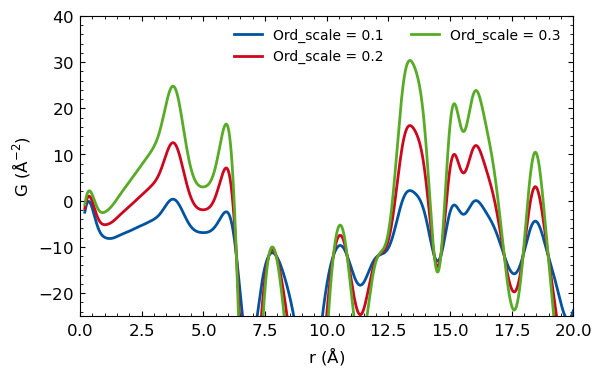

In [15]:
fig, gs = plot_defaults(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim(0, max(r))
ax.set_ylim(-25, 40)

# Display results and plot the fit
for pscale in [0.1, 0.2, 0.3]:
    fit.parascale = 0.2
    fit.ordscale = pscale
    r = fit.totpdf.profile.x
    gobs = fit.totpdf.profile.y

    # Get the calculated PDF and compute the difference between the calculated and
    # measured PDF
    totcalc = fit.totpdf.evaluate()  # calculated combined atomic and magnetic PDF
    magcalc = mpdf(
    fit.ordscale.value, fit.parascale.value, fit.th.value, fit.phi.value
    )  # just mPDF
    nuccalc = totcalc - magcalc  # just atomic PDF
    baseline = 1.6 * gobs.min()
    nucdiff = gobs - nuccalc
    totdiff = gobs - totcalc  # total fit residual
    results = FitResults(fit)

    ax.plot(r, magcalc + baseline, marker="None", lw=2, label=f"Ord_scale = {pscale}")






ax.set_xlabel(r"r ($\mathdefault{\AA}$)")
ax.set_ylabel(r"G ($\mathdefault{\AA^{-2}}$)")
#ax.plot(r, gobs, "bo", label="obs", markerfacecolor="none", markeredgecolor="C0",  markersize=2, alpha=0.9)
#ax.plot(r, totcalc, label="fit", alpha=1, color="C1")

#ax.plot(r, np.zeros_like(r) + 1.4 * baseline, "k", linewidth=0.1)
#ax.plot(r, totdiff + 1.4 * baseline, "g-", label="diff")
#ax.plot([],[], label=f"T = {Temperature} K", linestyle="")
plt.legend(frameon=False, ncol=2, fontsize=10)

plt.savefig(f"Sim_Ord_Scale.pdf")